In [57]:
import urllib.request
import matplotlib.pyplot as plt
import os
import glob
from skimage.feature import hog
import cv2
import numpy as np
from sklearn.cross_validation import train_test_split

import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [32]:
def download(url, file):
    """
    Download file from <url>
    :param url: URL to file
    :param file: Local file path
    """
    if not os.path.isfile(file):
        print('Downloading ' + file + '...')
        urllib.request.urlretrieve(url, file)
        print('Download Finished')
        
    else:
        print("File exists '{}' - skipping".format(file))


def draw_side_by_side(*images):
    cols = len(images)

    f, axes = plt.subplots(1, cols, figsize=(16, 6))
    f.tight_layout()
    f.subplots_adjust(left=-0.2, right=1, top=1., bottom=0., wspace=0., hspace=0.)

    if cols == 1:
        axes = [axes]

    for i in range(0,cols):
        a = axes[i]
        a.axis('off')
        a.imshow(images[i])

In [34]:
def get_test_images():
    images = glob.glob('data_sample/**/*.jpeg', recursive=True)
    print('images', len(images))
    cars = []
    notcars = []
    for image in images:
        if 'image' in image or 'extra' in image:
            notcars.append(image)
        else:
            cars.append(image)
    return cars, notcars


car_files, notcar_files = get_test_images()

images 2321


In [36]:
def load_images(filenames):
    return [plt.imread(f) for f in filenames]


car_images = load_images(car_files)
notcar_images = load_images(notcar_files)

print('images_loaded')

images_loaded


In [38]:

print('car shape: ', car_images[0].shape)
print('notcar shape: ', notcar_images[0].shape)
print('Num cars: ', len(car_images))
print('Num notcars: ', len(notcar_images))
print('dtype: ', car_images[0].dtype)

car shape:  (64, 64, 3)
notcar shape:  (64, 64, 3)
Num cars:  1196
Num notcars:  1125
dtype:  uint8


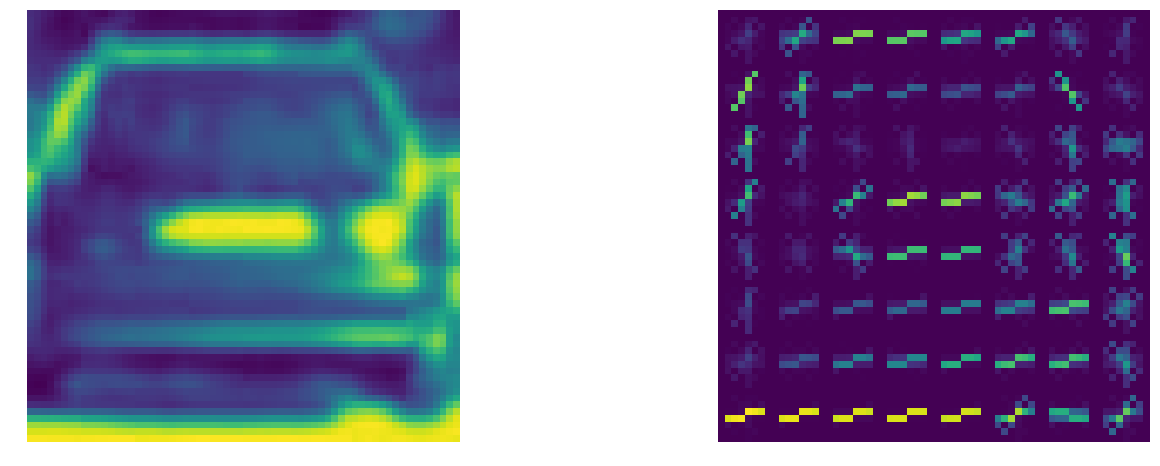

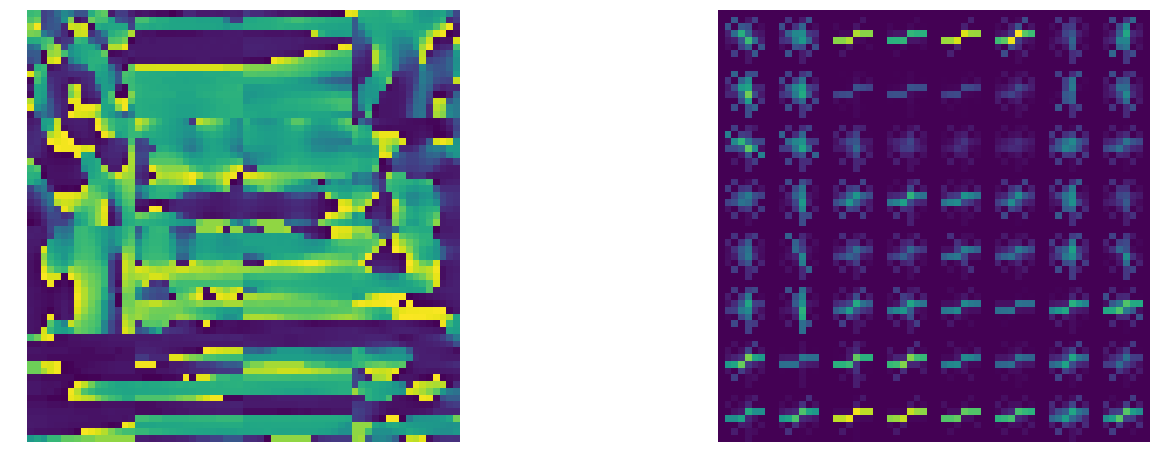

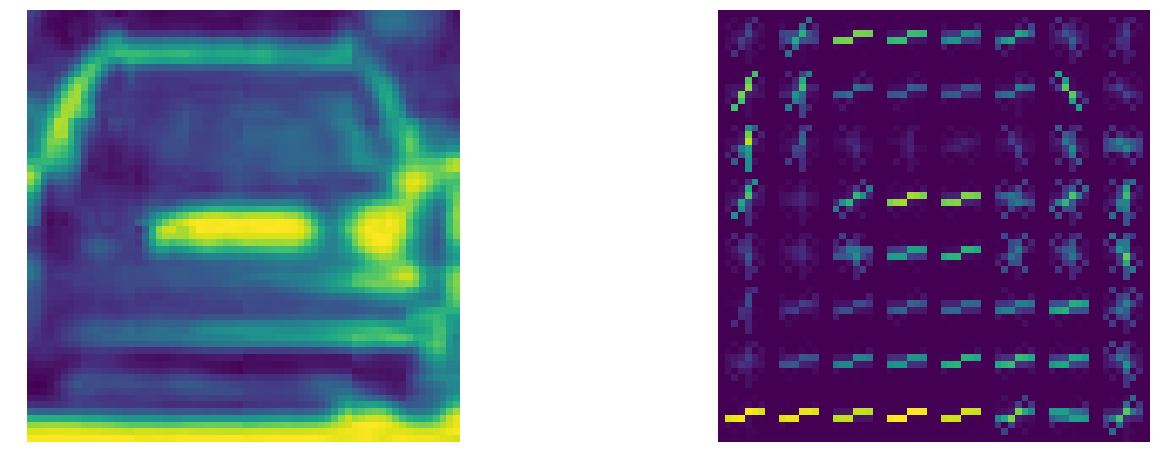

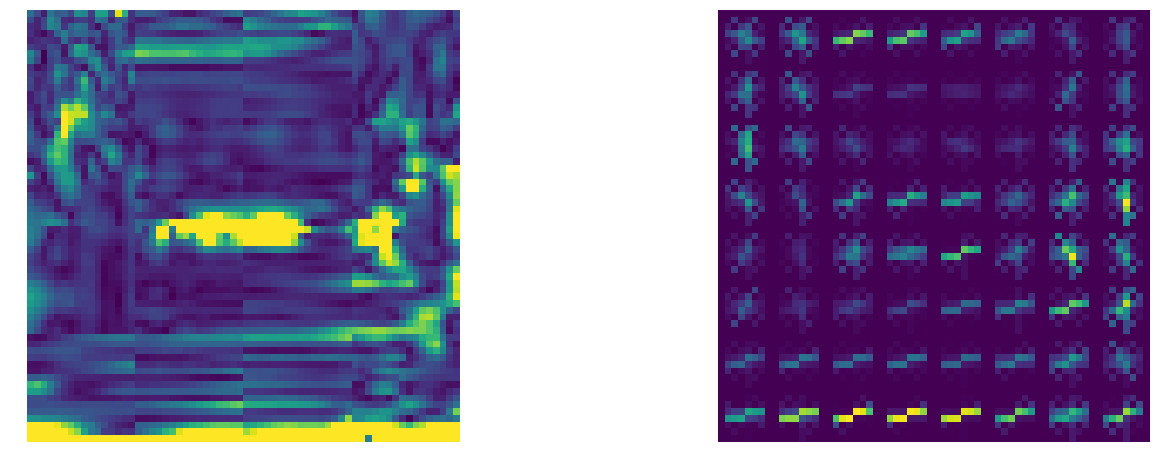

In [59]:
# Define a function to return HOG features and visualization
orient=9
pix_per_cell=8
cell_per_block=2


def image_to_hog(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=True):
    if vis:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  visualise=True, feature_vector=feature_vec,
                                  block_norm="L2-Hys")
        return features, hog_image
    else:
        features= hog(img, orientations=orient,
                      pixels_per_cell=(pix_per_cell, pix_per_cell),
                      cells_per_block=(cell_per_block, cell_per_block),
                      visualise=False, feature_vector=feature_vec,
                      block_norm="L2-Hys")
        return features


gray = cv2.cvtColor(car_images[0], cv2.COLOR_RGB2GRAY)
hog_gray = image_to_hog(gray, 9, 8, 2, vis=True)[1]

hls = cv2.cvtColor(car_images[0], cv2.COLOR_RGB2HLS)
h = hls[:,:,0]
l = hls[:,:,1]
s = hls[:,:,2]

hog_h = image_to_hog(h, 9, 8, 2, vis=True)[1]
hog_l = image_to_hog(l, 9, 8, 2, vis=True)[1]
hog_s = image_to_hog(s, 9, 8, 2, vis=True)[1]

draw_side_by_side(gray, hog_gray)
draw_side_by_side(h, hog_h)
draw_side_by_side(l, hog_l)
draw_side_by_side(s, hog_s)



I will choose the L channel for HOG gradients as the car stands out most in that channel.



# Preprocessing the images for training




In [ ]:
def train_svm(car_images, notcar_images, orient, pix_per_cell, cell_per_block, color_space, color_chan):
    print(
        'orient:', orient,
        'pix_per_cell:', pix_per_cell,
        'cell_per_block:', cell_per_block,
        'color_space:', color_space,
        'color_chan:', color_chan
    )
    

    def images_to_hogs(images):
        features_list = []
        for image in images:
            if color_space == 'HSV':
                image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            if color_space == 'LUV':
                image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            if color_space == 'HLS':
                image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            if color_space == 'YUV':
                image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            if color_space == 'YCrCb':
                image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
                
            if color_chan == 'ALL':
                image_hog = []
                for chan in range(image.shape[2]):
                    chan_hog = image_to_hog(image[:, :, chan],
                                            orient,
                                            pix_per_cell,
                                            cell_per_block,
                                            vis=False, feature_vec=True)
                    image_hog.append(chan_hog)
                image_hog = np.ravel(image_hog)
                
            else:
                image_hog = image_to_hog(image[:, :, color_chan],
                                        orient,
                                        pix_per_cell,
                                        cell_per_block,
                                        vis=False, feature_vec=True)
                

            
            features_list.append(image_hog)
            
        return features_list

    car_hogs = images_to_hogs(car_images)
    notcar_hogs = images_to_hogs(notcar_images)
    
    X = np.vstack((car_hogs, notcar_hogs)).astype(np.float64)
    y = np.hstack((np.ones(len(car_hogs)), np.zeros(len(notcar_hogs))))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    X_scaler = StandardScaler().fit(X_train)
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)
    
    svc = LinearSVC()
    svc.fit(X_train, y_train)
    print('Test acc:', round(svc.score(X_test, y_test), 4))
    print('')


orient: 7 pix_per_cell: 8 cell_per_block: 2 color_space: LUV color_chan: ALL


Test acc: 0.9699
orient: 8 pix_per_cell: 8 cell_per_block: 2 color_space: LUV color_chan: ALL


Test acc: 0.9806
orient: 9 pix_per_cell: 8 cell_per_block: 2 color_space: LUV color_chan: ALL


Test acc: 0.9849
orient: 10 pix_per_cell: 8 cell_per_block: 2 color_space: LUV color_chan: ALL


Test acc: 0.9892
orient: 11 pix_per_cell: 8 cell_per_block: 2 color_space: LUV color_chan: ALL


Test acc: 0.9892


In [89]:
train_svm(car_images, notcar_images, orient=7, pix_per_cell=8, cell_per_block=2, color_space='RGB', color_chan='ALL')
train_svm(car_images, notcar_images, orient=8, pix_per_cell=8, cell_per_block=2, color_space='HLS', color_chan='ALL')
train_svm(car_images, notcar_images, orient=9, pix_per_cell=8, cell_per_block=2, color_space='HSV', color_chan='ALL')
train_svm(car_images, notcar_images, orient=10, pix_per_cell=8, cell_per_block=2, color_space='LUV', color_chan='ALL')
train_svm(car_images, notcar_images, orient=11, pix_per_cell=8, cell_per_block=2, color_space='YCrCb', color_chan='ALL')

orient: 7 pix_per_cell: 8 cell_per_block: 2 color_space: RGB color_chan: ALL


Test acc: 0.9398
orient: 8 pix_per_cell: 8 cell_per_block: 2 color_space: HLS color_chan: ALL


Test acc: 0.957
orient: 9 pix_per_cell: 8 cell_per_block: 2 color_space: HSV color_chan: ALL


Test acc: 0.9441
orient: 10 pix_per_cell: 8 cell_per_block: 2 color_space: LUV color_chan: ALL


Test acc: 0.9892
orient: 11 pix_per_cell: 8 cell_per_block: 2 color_space: YCrCb color_chan: ALL


Test acc: 0.9806


### Color space choice
I will choose LUV as the color space

In [91]:
train_svm(car_images, notcar_images, orient=9, pix_per_cell=8, cell_per_block=2, color_space='LUV', color_chan=0)
train_svm(car_images, notcar_images, orient=9, pix_per_cell=8, cell_per_block=2, color_space='LUV', color_chan=1)
train_svm(car_images, notcar_images, orient=9, pix_per_cell=8, cell_per_block=2, color_space='LUV', color_chan=2)
train_svm(car_images, notcar_images, orient=9, pix_per_cell=8, cell_per_block=2, color_space='YCrCb', color_chan=0)
train_svm(car_images, notcar_images, orient=9, pix_per_cell=8, cell_per_block=2, color_space='YCrCb', color_chan=1)
train_svm(car_images, notcar_images, orient=9, pix_per_cell=8, cell_per_block=2, color_space='YCrCb', color_chan=2)

orient: 7 pix_per_cell: 8 cell_per_block: 2 color_space: LUV color_chan: ALL


Test acc: 0.9699
orient: 8 pix_per_cell: 8 cell_per_block: 2 color_space: LUV color_chan: ALL


Test acc: 0.9806
orient: 9 pix_per_cell: 8 cell_per_block: 2 color_space: LUV color_chan: ALL


Test acc: 0.9849
orient: 10 pix_per_cell: 8 cell_per_block: 2 color_space: LUV color_chan: ALL


Test acc: 0.9892
orient: 11 pix_per_cell: 8 cell_per_block: 2 color_space: LUV color_chan: ALL


Test acc: 0.9892


### Color channel choice

It looks like using all three channels gives better accuracy

In [93]:
train_svm(car_images, notcar_images, orient=7, pix_per_cell=8, cell_per_block=2, color_space='LUV', color_chan='ALL')
train_svm(car_images, notcar_images, orient=8, pix_per_cell=8, cell_per_block=2, color_space='LUV', color_chan='ALL')
train_svm(car_images, notcar_images, orient=9, pix_per_cell=8, cell_per_block=2, color_space='LUV', color_chan='ALL')
train_svm(car_images, notcar_images, orient=10, pix_per_cell=8, cell_per_block=2, color_space='LUV', color_chan='ALL')
train_svm(car_images, notcar_images, orient=11, pix_per_cell=8, cell_per_block=2, color_space='LUV', color_chan='ALL')

orient: 7 pix_per_cell: 8 cell_per_block: 2 color_space: LUV color_chan: ALL


Test acc: 0.9699
orient: 8 pix_per_cell: 8 cell_per_block: 2 color_space: LUV color_chan: ALL


Test acc: 0.9806
orient: 9 pix_per_cell: 8 cell_per_block: 2 color_space: LUV color_chan: ALL


Test acc: 0.9849
orient: 10 pix_per_cell: 8 cell_per_block: 2 color_space: LUV color_chan: ALL


Test acc: 0.9892
orient: 11 pix_per_cell: 8 cell_per_block: 2 color_space: LUV color_chan: ALL


Test acc: 0.9892


### Number of orients choice

It looks like more orients are better, however the difference levels off at 10. I will choose 10 as any more might be succeptible to overfitting.


In [99]:
train_svm(car_images, notcar_images, orient=10, pix_per_cell=4, cell_per_block=2, color_space='LUV', color_chan='ALL')
train_svm(car_images, notcar_images, orient=10, pix_per_cell=8, cell_per_block=2, color_space='LUV', color_chan='ALL')
train_svm(car_images, notcar_images, orient=10, pix_per_cell=16, cell_per_block=2, color_space='LUV', color_chan='ALL')
train_svm(car_images, notcar_images, orient=10, pix_per_cell=32, cell_per_block=2, color_space='LUV', color_chan='ALL')


orient: 10 pix_per_cell: 4 cell_per_block: 2 color_space: LUV color_chan: ALL


Test acc: 0.9892
orient: 10 pix_per_cell: 8 cell_per_block: 2 color_space: LUV color_chan: ALL


Test acc: 0.9892
orient: 10 pix_per_cell: 16 cell_per_block: 2 color_space: LUV color_chan: ALL


Test acc: 0.9871
orient: 10 pix_per_cell: 32 cell_per_block: 2 color_space: LUV color_chan: ALL


Test acc: 0.9828


### Pixels per cell
I will choose 16 - higher than 8 - as I believe it will help reduce the number of features, which should help reduce overfitting. 

In [96]:
train_svm(car_images, notcar_images, orient=10, pix_per_cell=8, cell_per_block=1, color_space='LUV', color_chan='ALL')
train_svm(car_images, notcar_images, orient=10, pix_per_cell=8, cell_per_block=2, color_space='LUV', color_chan='ALL')
train_svm(car_images, notcar_images, orient=10, pix_per_cell=8, cell_per_block=4, color_space='LUV', color_chan='ALL')

orient: 10 pix_per_cell: 8 cell_per_block: 1 color_space: LUV color_chan: ALL


Test acc: 0.9785
orient: 10 pix_per_cell: 8 cell_per_block: 2 color_space: LUV color_chan: ALL


Test acc: 0.9892
orient: 10 pix_per_cell: 8 cell_per_block: 4 color_space: LUV color_chan: ALL


Test acc: 0.9828


### Cell per block choice
I will choose 2 cells per block